# OptimizingDelivery Analysis

## Import libraries

In [1]:
import os 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

## Import Data

In [2]:
# Import directory
%store -r optimizingdelivery_data_dir

In [3]:
# Define dataframes and dataframe names
dataframe_names = ['customers', 'dates_2022', 'products', 'target_orders', 'order_lines', 'orders_aggregate']

In [4]:
# Function to import or reset dataframes
def import_reset():

    # Read parquet to import and if local instances exist then overwrite, effectively resetting the dataframes
    for name in dataframe_names:
        file_path = os.path.join(optimizingdelivery_data_dir, f'{name}.parquet')
        globals()[f'od_{name}'] = pd.read_parquet(file_path)

In [5]:
# Import dataframes
import_reset()

In [6]:
print(od_customers.shape)
print(od_dates_2022.shape)
print(od_products.shape)
print(od_target_orders.shape)
print(od_order_lines.shape)
print(od_orders_aggregate.shape)

(35, 3)
(365, 4)
(18, 3)
(35, 4)
(57096, 13)
(31729, 6)


## Exploration / Verification

In [7]:
od_order_lines.columns

Index(['order_id', 'order_placement_date', 'customer_id', 'product_id',
       'order_qty', 'agreed_delivery_date', 'actual_delivery_date',
       'delivery_qty', 'in_full', 'on_time', 'on_time_in_full',
       'line_fill_rate_pct', 'volume_fill_rate_pct'],
      dtype='object')

### Order Metrics

In [8]:
# Group order id by minimum binary to only include orders where all lines = 1
order_split = od_order_lines.groupby('order_id')[['on_time', 'in_full']].min().reset_index()

# Calculate total orders for each metric
total_orders = order_split['order_id'].nunique()

In [9]:
# Calculate total orders for each metric
print('Total Orders:', total_orders)
print('Total Only On Time Orders:', order_split[(order_split['on_time'] == 1) & (order_split['in_full'] == 0)]['order_id'].nunique())
print('Total Only In Full Orders:', order_split[(order_split['on_time'] == 0) & (order_split['in_full'] == 1)]['order_id'].nunique())
print('Total On Time & In Full Orders:', order_split[(order_split['on_time'] == 1) & (order_split['in_full'] == 1)]['order_id'].nunique())
print('Total Neither On Time or In Full Orders:', order_split[(order_split['on_time'] == 0) & (order_split['in_full'] == 0)]['order_id'].nunique())

Total Orders: 31729
Total Only On Time Orders: 9522
Total Only In Full Orders: 7539
Total On Time & In Full Orders: 9208
Total Neither On Time or In Full Orders: 5460


In [10]:
# Parts equal total
9522 + 7539 + 9208 + 5460

31729

In [11]:
# Calculate percent of total orders for each metric
print('Total Orders:', total_orders)
print('Total Only On Time Orders:', round((order_split[(order_split['on_time'] == 1) & (order_split['in_full'] == 0)]['order_id'].nunique() / total_orders) * 100, 2), '%')
print('Total Only In Full Orders:', round((order_split[(order_split['on_time'] == 0) & (order_split['in_full'] == 1)]['order_id'].nunique() / total_orders) * 100, 2), '%')
print('Total On Time & In Full Orders:', round((order_split[(order_split['on_time'] == 1) & (order_split['in_full'] == 1)]['order_id'].nunique() / total_orders) * 100, 2), '%')
print('Total Neither On Time or In Full Orders:', round((order_split[(order_split['on_time'] == 0) & (order_split['in_full'] == 0)]['order_id'].nunique() / total_orders) * 100, 2), '%')

Total Orders: 31729
Total Only On Time Orders: 30.01 %
Total Only In Full Orders: 23.76 %
Total On Time & In Full Orders: 29.02 %
Total Neither On Time or In Full Orders: 17.21 %


In [12]:
# Parts equal total
30.01 + 23.76 + 29.02 + 17.21

100.0

In [13]:
# Calculate percent of total orders for each metric
# This includes overlap, not only
print('Total Orders:', total_orders)
print('Total On Time Orders:', round((order_split[order_split['on_time'] == 1]['order_id'].nunique() / total_orders) * 100, 2), '%')
print('Total Only In Full Orders:', round((order_split[order_split['in_full'] == 1]['order_id'].nunique() / total_orders) * 100, 2), '%')
print('Total On Time & In Full Orders:', round((order_split[(order_split['on_time'] == 1) & (order_split['in_full'] == 1)]['order_id'].nunique() / total_orders) * 100, 2), '%')
print('Total Neither On Time or In Full Orders:', round((order_split[(order_split['on_time'] == 0) & (order_split['in_full'] == 0)]['order_id'].nunique() / total_orders) * 100, 2), '%')

Total Orders: 31729
Total On Time Orders: 59.03 %
Total Only In Full Orders: 52.78 %
Total On Time & In Full Orders: 29.02 %
Total Neither On Time or In Full Orders: 17.21 %


In [14]:
# Calculate targets percents for each metric
print('Total Orders:', total_orders)
print('On Time Target:', round(od_target_orders['ontime_target%'].mean(), 2))
print('In Full Target:', round(od_target_orders['infull_target%'].mean(), 2))
print('On Time & In Full Target:', round(od_target_orders['otif_target%'].mean(), 2))
print('Neither Target:', 5)

Total Orders: 31729
On Time Target: 86.09
In Full Target: 76.51
On Time & In Full Target: 65.91
Neither Target: 5


### Customer Metrics

In [15]:
# Group by customer id
customers_id_split = od_order_lines.groupby('customer_id')['order_id'].nunique().reset_index().rename(columns={'order_id': 'n_orders'})

# Find total orders percent
customers_id_split['total_orders_pct'] = round(((customers_id_split['n_orders'] / total_orders) * 100), 2)

# Merge to show customer_name
customers_id_split = pd.merge(customers_id_split, od_customers, on='customer_id')

customers_id_split.head(10)

,customer_id,n_orders,total_orders_pct,customer_name,city
0,789101,821,2.59,Vijay Stores,Surat
1,789102,832,2.62,Vijay Stores,Ahmedabad
2,789103,815,2.57,Vijay Stores,Vadodara
3,789121,1219,3.84,Coolblue,Ahmedabad
4,789122,1218,3.84,Coolblue,Vadodara
5,789201,784,2.47,Rel Fresh,Surat
6,789202,843,2.66,Rel Fresh,Ahmedabad
7,789203,830,2.62,Rel Fresh,Vadodara
8,789220,799,2.52,Atlas Stores,Surat
9,789221,847,2.67,Atlas Stores,Ahmedabad


In [16]:
# Parts equal total
customers_id_split['total_orders_pct'].sum()

99.99

In [17]:
# Group by customer name
customers_id_split.groupby('customer_name')['total_orders_pct'].sum().sort_values(ascending=False)

customer_name
Lotus Mart           11.19
Acclaimed Stores     11.06
Vijay Stores          7.78
Rel Fresh             7.75
Coolblue              7.68
Propel Mart           7.63
Logic Stores          5.28
Info Stores           5.26
Expression Stores     5.23
Sorefoz Mart          5.23
Expert Mart           5.22
Atlas Stores          5.19
Chiptec Stores        5.18
Elite Mart            5.16
Viveks Stores         5.15
Name: total_orders_pct, dtype: float64

In [18]:
# Merge with customers to get customer name
customer_name_split = pd.merge(od_order_lines, od_customers, on='customer_id').groupby(['order_id', 'customer_name'])[['on_time', 'in_full']].min().reset_index()

# Get totals for each metric grouped by city
customer_name_split_total = customer_name_split.groupby('customer_name')['order_id'].nunique().reset_index().rename(columns={'order_id':'total_orders'})
customer_name_split_ot = customer_name_split[customer_name_split['on_time'] == 1].groupby('customer_name')['order_id'].nunique().reset_index().rename(columns={'order_id':'on_time'})
customer_name_split_if = customer_name_split[customer_name_split['in_full'] == 1].groupby('customer_name')['order_id'].nunique().reset_index().rename(columns={'order_id':'in_full'})
customer_name_split_otif = customer_name_split[(customer_name_split['on_time'] == 1) & (customer_name_split['in_full'] == 1)].groupby('customer_name')['order_id'].nunique().reset_index().rename(columns={'order_id':'otif'})
customer_name_split_neither = customer_name_split[(customer_name_split['on_time'] == 0) & (customer_name_split['in_full'] == 0)].groupby('customer_name')['order_id'].nunique().reset_index().rename(columns={'order_id':'neither'})

# Merge
customers_split = pd.merge(customer_name_split_total, customer_name_split_ot, on='customer_name')
customers_split = pd.merge(customers_split, customer_name_split_if, on='customer_name')
customers_split = pd.merge(customers_split, customer_name_split_otif, on='customer_name')
customers_split = pd.merge(customers_split, customer_name_split_neither, on='customer_name')

customers_split

,customer_name,total_orders,on_time,in_full,otif,neither
0,Acclaimed Stores,3510,1033,1838,543,1182
1,Atlas Stores,1646,1182,984,651,131
2,Chiptec Stores,1642,1176,991,636,111
3,Coolblue,2437,710,1090,335,972
4,Elite Mart,1637,1186,621,399,229
5,Expert Mart,1657,1202,991,648,112
6,Expression Stores,1662,1162,1011,638,127
7,Info Stores,1669,1184,687,426,224
8,Logic Stores,1676,1187,1008,650,131
9,Lotus Mart,3550,998,1894,580,1238


In [19]:
# Merge to get customer targets
customer_targets_split = pd.merge(od_target_orders, od_customers, on='customer_id')
customer_targets_split = round(customer_targets_split.groupby('customer_name')[['ontime_target%', 'infull_target%', 'otif_target%']].mean(), 2)

customer_targets_split

,ontime_target%,infull_target%,otif_target%
customer_name,,,
Acclaimed Stores,76.33,75.33,57.67
Atlas Stores,88.00,78.00,68.50
Chiptec Stores,89.00,81.00,72.00
Coolblue,77.00,71.00,54.50
Elite Mart,91.00,73.00,66.50
Expert Mart,91.00,80.00,73.00
Expression Stores,88.50,78.00,69.00
Info Stores,92.00,71.00,65.50
Logic Stores,87.50,76.00,66.50


### Line Metrics

In [20]:
# Calculate total lines for each metric
print('Total Orders:', od_order_lines['order_id'].nunique())
print('Total On Time Orders:', od_order_lines[od_order_lines['on_time'] == 1]['order_id'].nunique())
print('Total In Full Orders:', od_order_lines[od_order_lines['in_full'] == 1]['order_id'].nunique())
print('Total On Time & In Full Orders:', od_order_lines[od_order_lines['on_time_in_full'] == 1]['order_id'].nunique())

Total Orders: 31729
Total On Time Orders: 18730
Total In Full Orders: 23932
Total On Time & In Full Orders: 15121


In [21]:
# Calculate percent of total lines for each metric
print('On Time Lines Percent:', round(len(od_order_lines[od_order_lines['on_time'] == 1]) / len(od_order_lines) * 100, 2))
print('In Full Lines Percent:', round(len(od_order_lines[od_order_lines['in_full'] == 1]) / len(od_order_lines) * 100, 2))
print('On Time & In Full Lines Percent:', round(len(od_order_lines[od_order_lines['on_time_in_full'] == 1]) / len(od_order_lines) * 100, 2))

On Time Lines Percent: 71.12
In Full Lines Percent: 65.96
On Time & In Full Lines Percent: 47.95


In [22]:
od_order_lines.sample(5)

,order_id,order_placement_date,customer_id,product_id,order_qty,agreed_delivery_date,actual_delivery_date,delivery_qty,in_full,on_time,on_time_in_full,line_fill_rate_pct,volume_fill_rate_pct
52005,FAUG814421103,2022-08-13,789421,25891103,432,2022-08-14,2022-08-14,410,0,1,0,0.0,94.91
2165,FMR39420101,2022-03-07,789420,25891101,361,2022-03-09,2022-03-10,361,1,0,0,100.0,100.00
55964,FAUG829221502,2022-08-26,789221,25891101,455,2022-08-29,2022-08-29,455,1,1,1,100.0,100.00
38097,FJUL73522603,2022-06-30,789522,25891303,56,2022-07-03,2022-07-05,56,1,0,0,100.0,100.00
56267,FAUG829720601,2022-08-27,789720,25891601,182,2022-08-29,2022-08-29,146,0,1,0,50.0,94.12


### Plots

In [23]:
od_target_orders.sample(20)

,customer_id,ontime_target%,infull_target%,otif_target%
16,789403,86,79,68
17,789420,75,79,59
21,789503,86,82,71
23,789521,78,79,62
2,789203,92,76,70
24,789522,76,79,60
30,789622,90,79,71
28,789703,85,78,66
12,789320,91,81,74
4,789303,88,78,69


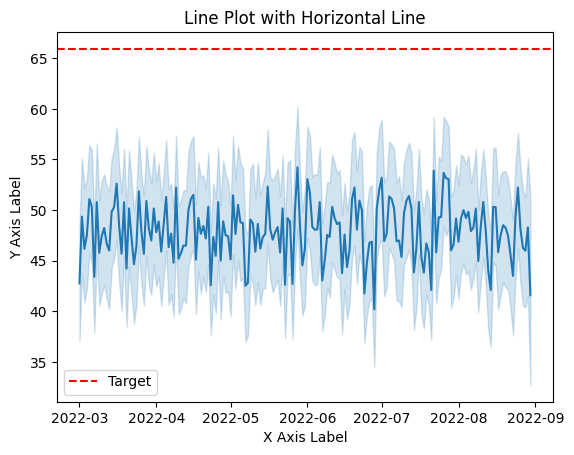

In [24]:
# Assuming `od_order_lines` and `od_target_orders` contain the required data

# Create a Matplotlib figure and axis
fig, ax = plt.subplots()

# Plot the line plot using Seaborn
sns.lineplot(x=od_order_lines['order_placement_date'], y=od_order_lines['on_time_in_full'] * 100, ax=ax)

# Plot the horizontal line using Matplotlib
mean_value = od_target_orders['otif_target%'].mean()
ax.axhline(y=mean_value, color='r', linestyle='--', label='Target')

# Add labels and title
ax.set_xlabel('X Axis Label')
ax.set_ylabel('Y Axis Label')
ax.set_title('Line Plot with Horizontal Line')

# Show legend
ax.legend()

# Show the plot
plt.show()


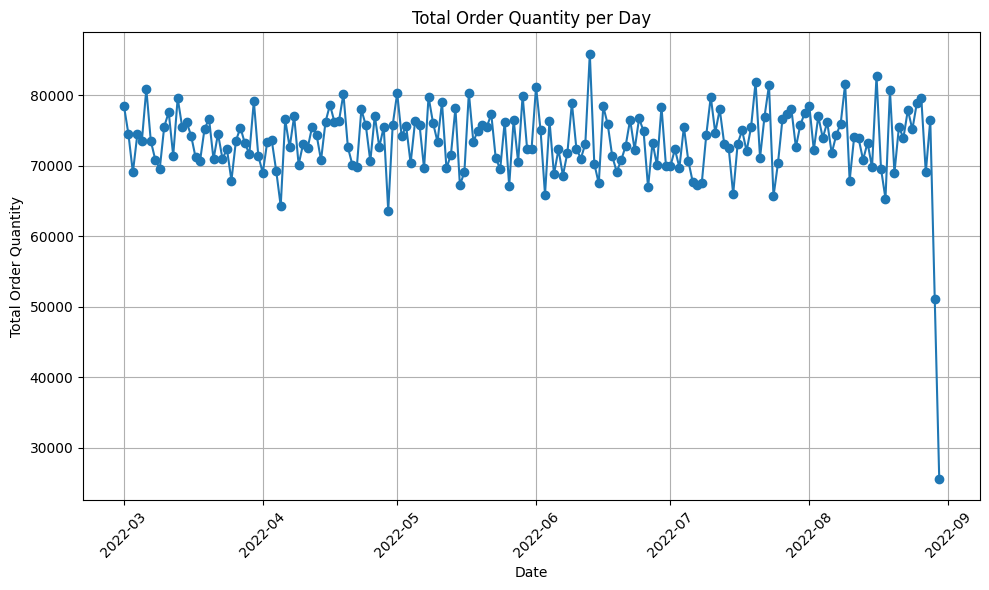

In [25]:
# Plot quantity ordered over time

# Group sum by date
plot_data = od_order_lines.groupby(od_order_lines['order_placement_date'].dt.date)['order_qty'].sum()

# Plot
plt.figure(figsize=(10, 6))

plot_data.plot(marker='o', grid=True)

plt.title('Total Order Quantity per Day')
plt.xlabel('Date')
plt.ylabel('Total Order Quantity')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

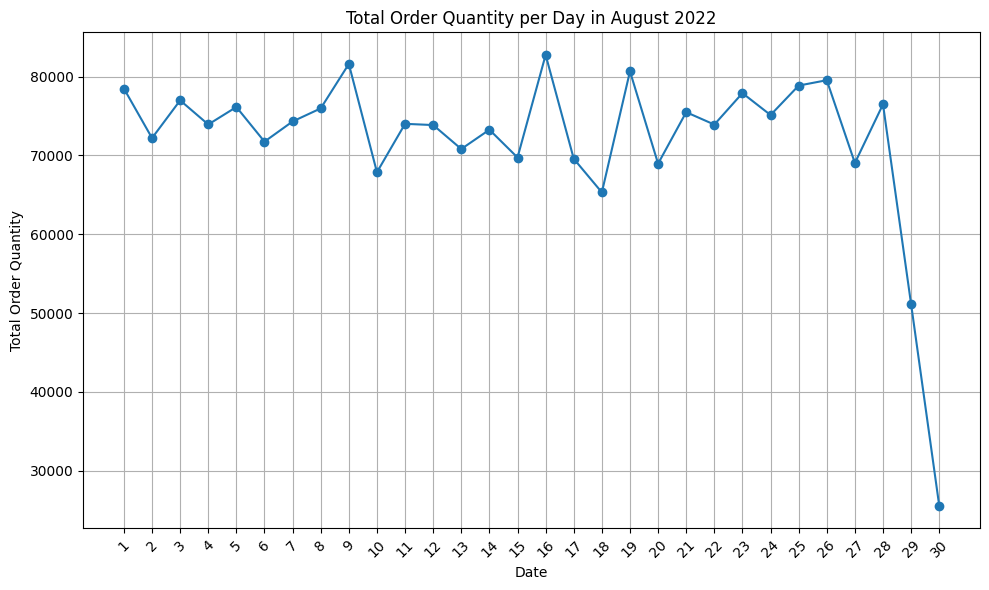

In [26]:
# Plot quantity ordered over time, highlight outliers in august

# Group sum by date
plot_data = od_order_lines[od_order_lines['order_placement_date'].dt.date > pd.to_datetime('2022-07-31').date()].groupby(od_order_lines['order_placement_date'].dt.day)['order_qty'].sum()

# Plot
plt.figure(figsize=(10, 6))

plot_data.plot(marker='o', grid=True)

plt.title('Total Order Quantity per Day in August 2022')
plt.xlabel('Date')
plt.ylabel('Total Order Quantity')
plt.xticks(rotation=45, ticks=plot_data.index)

plt.tight_layout()
plt.show()

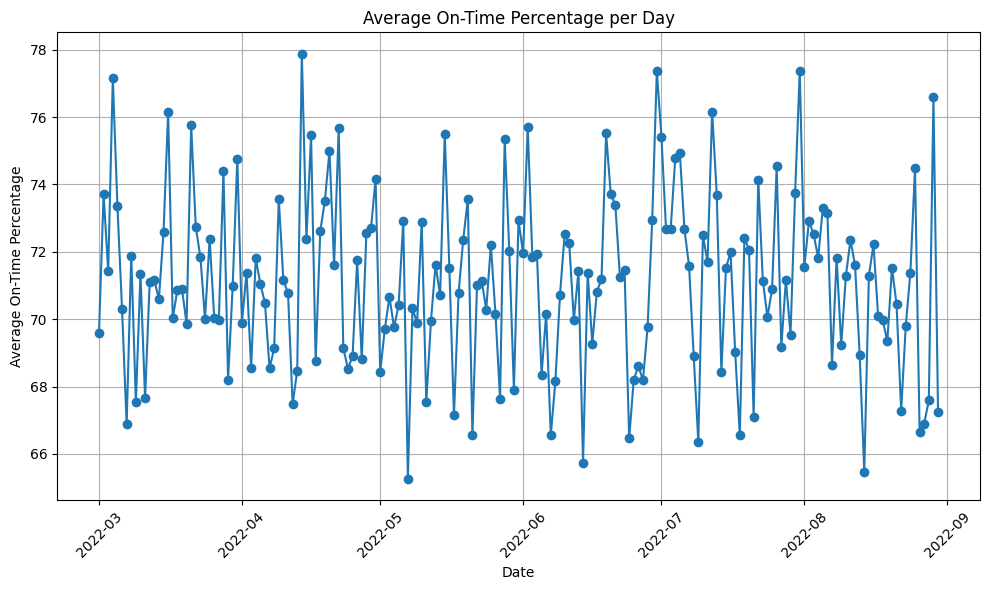

In [27]:
# Plot percent of deliveries that are on time over time

# Group percent on_time by date
plot_data = od_order_lines.groupby(od_order_lines['order_placement_date'].dt.date)['on_time'].mean() * 100

# Plot
plt.figure(figsize=(10, 6))
plot_data.plot(marker='o', grid=True)

plt.title('Average On-Time Percentage per Day')
plt.xlabel('Date')
plt.ylabel('Average On-Time Percentage')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

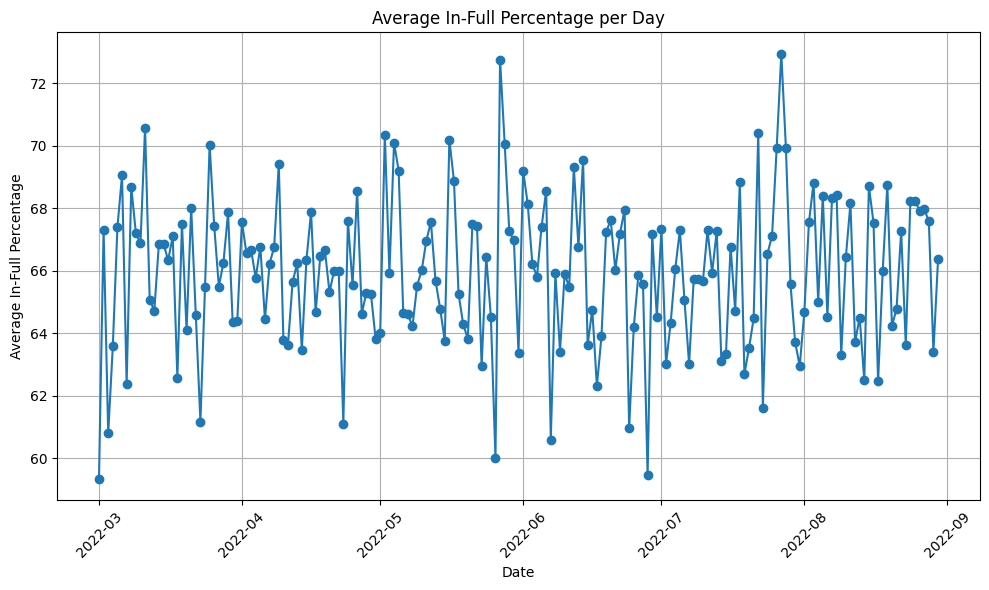

In [28]:
# Plot percent of deliveries that are in full over time

# Group percent in_full by date
plot_data = od_order_lines.groupby(od_order_lines['order_placement_date'].dt.date)['in_full'].mean() * 100

# Plot
plt.figure(figsize=(10, 6))
plot_data.plot(marker='o', grid=True)

plt.title('Average In-Full Percentage per Day')
plt.xlabel('Date')
plt.ylabel('Average In-Full Percentage')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

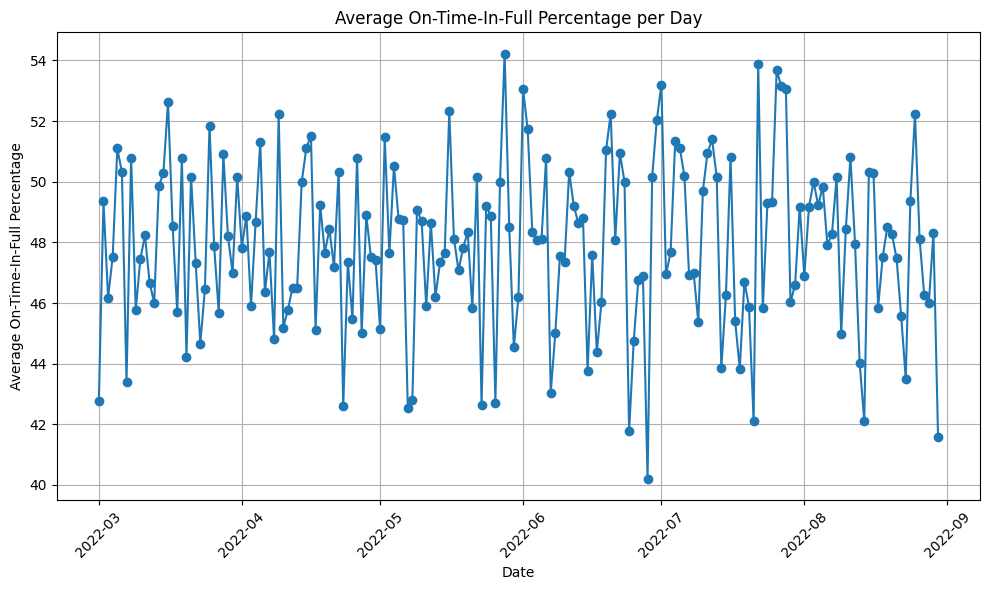

In [29]:
# Plot percent of deliveries that are on time and in full over time

# Group by date and calculate the mean of on_time_in_full for each day
plot_data = od_order_lines.groupby(od_order_lines['order_placement_date'].dt.date)['on_time_in_full'].mean() * 100

# Plot
plt.figure(figsize=(10, 6))
plot_data.plot(marker='o', grid=True)

plt.title('Average On-Time-In-Full Percentage per Day')
plt.xlabel('Date')
plt.ylabel('Average On-Time-In-Full Percentage')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Machine Learning Model

##### Create Predictive Models:
  
Building predictive models to determine whether an order line meets targets like 'in_full', 'on_time', or 'otif' is a fundamental step. You can use various machine learning algorithms like logistic regression, random forests, or gradient boosting, depending on the complexity of your data and the desired accuracy of predictions.
Ensure you have labeled data where each order line is marked as 'true' or 'false' for meeting the targets. Also, pay attention to feature engineering to extract relevant information from your dataset.
  
##### Identify Associated Variables:
  
Analyzing the importance of variables associated with failure for 'in_full', 'on_time', or 'otif' is crucial for understanding the root causes of delivery failures. You can use techniques like feature importance analysis from tree-based models or permutation importance to identify the most influential features.
Understanding these variables can provide insights into areas of improvement in your production process. For example, if a specific product category or supplier consistently results in delivery failures, you can focus on improving those aspects.
Predict Targets and Evaluate Model Performance:
  
After training your predictive models, assess their performance using appropriate evaluation metrics such as accuracy, precision, recall, F1-score, or area under the ROC curve (AUC). Ensure you use proper validation techniques like cross-validation to estimate the model's generalization performance.
It's essential to have reliable models that accurately predict whether an order line meets the specified targets. These models will serve as the basis for making informed decisions and implementing improvements in your production process.
  
##### Extract Insights for Improvement:
  
Once you have reliable predictive models, leverage the insights gained from them to suggest improvements in your production process. For example, if certain factors consistently lead to delivery failures, you can take corrective actions such as optimizing inventory management, improving supplier relationships, enhancing transportation logistics, or refining order processing workflows.
Continuously monitor the performance of your production process and iteratively refine your strategies based on the insights provided by the predictive models.

### Import libraries

In [30]:
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance

from scipy.stats import randint, uniform

### Prepare model data

#### Incorporate as much relevant data into the training model

In [31]:
model_data = od_order_lines.copy()

In [32]:
# Create dervived columns for order_placement_date
model_data = pd.merge(model_data, od_dates_2022, how='left', left_on='order_placement_date', right_on='date')

model_data['order_placement_month'] = model_data['month'].astype('int64')
model_data['order_placement_day'] = model_data['order_placement_date'].dt.day.astype('int64')
model_data['order_placement_week_no'] = model_data['week_number'].astype('int64')

# Organize columns
model_data = model_data[['order_id', 'order_placement_date', 'order_placement_month', 'order_placement_day', 'order_placement_week_no', 
                        'customer_id', 'product_id','order_qty', 'agreed_delivery_date', 'actual_delivery_date',
                        'delivery_qty', 'in_full', 'on_time', 'on_time_in_full']].copy()

In [33]:
# Create dervived columns for agreed_delivery_date
model_data = pd.merge(model_data, od_dates_2022, how='left', left_on='agreed_delivery_date', right_on='date')

model_data['agreed_delivery_month'] = model_data['month'].astype('int64')
model_data['agreed_delivery_day'] = model_data['agreed_delivery_date'].dt.day.astype('int64')
model_data['agreed_delivery_week_no'] = model_data['week_number'].astype('int64')

# Organize columns
model_data = model_data[['order_id', 'order_placement_date', 'order_placement_month', 'order_placement_day', 'order_placement_week_no', 
                        'customer_id', 'product_id','order_qty', 
                        'agreed_delivery_date', 'agreed_delivery_month', 'agreed_delivery_day', 'agreed_delivery_week_no', 
                        'actual_delivery_date',
                        'delivery_qty', 'in_full', 'on_time', 'on_time_in_full',]].copy()

In [34]:
# Create dervived columns for actual_delivery_date
model_data = pd.merge(model_data, od_dates_2022, how='left', left_on='actual_delivery_date', right_on='date')

model_data['actual_delivery_month'] = model_data['month'].astype('int64')
model_data['actual_delivery_day'] = model_data['actual_delivery_date'].dt.day.astype('int64')
model_data['actual_delivery_week_no'] = model_data['week_number'].astype('int64')

# Organize columns
model_data = model_data[['order_id', 'order_placement_date', 'order_placement_month', 'order_placement_day', 'order_placement_week_no', 
                        'customer_id', 'product_id','order_qty', 
                        'agreed_delivery_date', 'agreed_delivery_month', 'agreed_delivery_day', 'agreed_delivery_week_no', 
                        'actual_delivery_date', 'actual_delivery_month', 'actual_delivery_day', 'actual_delivery_week_no',
                        'delivery_qty', 'in_full', 'on_time', 'on_time_in_full',]].copy()

##### Merge customer

In [35]:
# Merge customer columns
model_data = pd.merge(model_data, od_customers, how='left', on='customer_id')

##### Merge products

In [36]:
# Merge customer columns
model_data = pd.merge(model_data, od_products, how='left', on='product_id')

#### Refine model data datatypes

In [37]:
model_data.dtypes

order_id                           object
order_placement_date       datetime64[ns]
order_placement_month               int64
order_placement_day                 int64
order_placement_week_no             int64
customer_id                         int64
product_id                          int64
order_qty                           int64
agreed_delivery_date       datetime64[ns]
agreed_delivery_month               int64
agreed_delivery_day                 int64
agreed_delivery_week_no             int64
actual_delivery_date       datetime64[ns]
actual_delivery_month               int64
actual_delivery_day                 int64
actual_delivery_week_no             int64
delivery_qty                        int64
in_full                             int64
on_time                             int64
on_time_in_full                     int64
customer_name                      object
city                               object
product_name                       object
category                          

In [38]:
# Create categorical codes for object datatypes
model_data['order_code'] = model_data['order_id'].astype('category').cat.codes
model_data['customer_name_code'] = model_data['customer_name'].astype('category').cat.codes
model_data['city_code'] = model_data['city'].astype('category').cat.codes
model_data['product_name_code'] = model_data['product_name'].astype('category').cat.codes
model_data['category_code'] = model_data['category'].astype('category').cat.codes

In [39]:
# Organize columns
model_data = model_data[[   'order_id',
                            'order_code',
                            'order_placement_date',
                            'order_placement_month',
                            'order_placement_day',
                            'order_placement_week_no',
                            'customer_id',
                            'customer_name',
                            'customer_name_code',
                            'city',
                            'city_code',
                            'product_id',
                            'product_name',
                            'product_name_code',
                            'category',
                            'category_code',
                            'order_qty',
                            'agreed_delivery_date',
                            'agreed_delivery_month',
                            'agreed_delivery_day',
                            'agreed_delivery_week_no',
                            'actual_delivery_date',
                            'actual_delivery_month',
                            'actual_delivery_day',
                            'actual_delivery_week_no',
                            'delivery_qty',
                            'in_full',
                            'on_time',
                            'on_time_in_full']]

# Sort model data by order placement date and reset the index
model_data.sort_values('order_placement_date', inplace=True)
model_data.reset_index(drop=True, inplace=True)

In [40]:
#Check shape and nan rows
print(model_data.shape)
print('nans rows:', model_data.isna().sum().sum())

(57096, 29)
nans rows: 0


In [41]:
model_data.dtypes

order_id                           object
order_code                          int16
order_placement_date       datetime64[ns]
order_placement_month               int64
order_placement_day                 int64
order_placement_week_no             int64
customer_id                         int64
customer_name                      object
customer_name_code                   int8
city                               object
city_code                            int8
product_id                          int64
product_name                       object
product_name_code                    int8
category                           object
category_code                        int8
order_qty                           int64
agreed_delivery_date       datetime64[ns]
agreed_delivery_month               int64
agreed_delivery_day                 int64
agreed_delivery_week_no             int64
actual_delivery_date       datetime64[ns]
actual_delivery_month               int64
actual_delivery_day               

In [42]:
# Save prepared model_data to reset
prepared_model_data = model_data.copy()

#### Split model data into train, validation and holdout

In [43]:
model_data.shape

(57096, 29)

In [44]:
# Split into train data and holdout data
train_data = model_data[:int(len(model_data) * 0.85)]
holdout_data = model_data[int(len(model_data)* 0.85):]

In [45]:
print(model_data.shape)
print(train_data.shape)
print(holdout_data.shape)

(57096, 29)
(48531, 29)
(8565, 29)


In [46]:
# Define features and targets
features = ['order_code',
            'order_placement_month',
            'order_placement_day',
            'order_placement_week_no',
            'customer_id',
            'customer_name_code',
            'city_code',
            'product_id',
            'product_name_code',
            'category_code',
            'order_qty',
            'agreed_delivery_month',
            'agreed_delivery_day',
            'agreed_delivery_week_no']
targets = ['on_time', 'in_full']

In [47]:
# Split train data and holdout data into features and targets
X_ = train_data[features]
y_ = train_data[targets]

X_holdout = holdout_data[features]
y_holdout = holdout_data[targets]

In [48]:
# Train test split the train data to create the validation data
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.2, random_state=9)

In [49]:
print(X_.shape)
print(y_.shape)
print(X_holdout.shape)
print(y_holdout.shape)

(48531, 14)
(48531, 2)
(8565, 14)
(8565, 2)


In [50]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(38824, 14)
(38824, 2)
(9707, 14)
(9707, 2)


### Define Functions

In [51]:
# Dictionary to store function information
all_functions = {}

In [52]:
# Function to reset model data
def reset_model_data():
    global model_data
    model_data = prepared_model_data.copy()

# Add function to dictionary 
all_functions.update({'reset_model_data:': '[ ]'})

In [53]:
# Function to split model data into train, validation and holdout

# Define features and targets
features = ['order_code',
            'order_placement_month',
            'order_placement_day',
            'order_placement_week_no',
            'customer_id',
            'customer_name_code',
            'city_code',
            'product_id',
            'product_name_code',
            'category_code',
            'order_qty',
            'agreed_delivery_month',
            'agreed_delivery_day',
            'agreed_delivery_week_no']
targets = ['on_time', 'in_full']

def split_data(model_data):

    # Split into train data and holdout data
    train_data = model_data[:int(len(model_data) * 0.85)]
    holdout_data = model_data[int(len(model_data)* 0.85):]

    # Split train data and holdout data by features and targets
    X_ = train_data[features]
    y_ = train_data[targets]

    X_holdout = holdout_data[features]
    y_holdout = holdout_data[targets]

    # Train test split the train data to create the validation data
    X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.2, random_state=9) 

    return X_train, X_val, y_train, y_val, X_holdout, y_holdout

# Add function to dictionary 
all_functions.update({'split_data:': '[model_data]'})

In [54]:
# Function to cross validate accuracy scores and auc scores

# Define scorer
accuracy_scorer = make_scorer(accuracy_score)

# Define a KFold with shuffle=True and folds=10
kf = KFold(n_splits=10, shuffle=True, random_state=9)

def cross_validate(model, model_features, model_targets):

    # Cross validate accuracy and auc
    accuracy_scores = cross_val_score(model, model_features, model_targets, cv=kf, scoring=accuracy_scorer)
    auc_scores = cross_val_score(model, model_features, model_targets, cv=kf, scoring='roc_auc')

    # Print scores 
    print('Variance: {:.10f}'.format(accuracy_scores.var()))
    print('Mean AUC:', auc_scores.mean())
    print('Mean Accuracy:', accuracy_scores.mean())

# Add function to dictionary 
all_functions.update({'cross_validate:': ['model', 'model_features','model_targets']})

In [55]:
# Function to hypertune parameters
def tune(model, tune_param):
    # Ignore failed fit warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # Fit model
        random_search = RandomizedSearchCV(estimator=model, 
                                        param_distributions=tune_param, 
                                        n_iter=150, 
                                        cv=5, 
                                        random_state=9, 
                                        n_jobs=-1, 
                                        scoring='accuracy')
        random_search.fit(X_train, y_train)
        
        # Define failed fit count
        failed_fits = np.sum(np.isnan(random_search.cv_results_['mean_test_score']))

        # Define best estimators
        best_estimator = random_search.best_estimator_.estimators_[0]

        # Filter out hyperparameters with None or 0 values
        hyperparameters = {param: value for param, value in best_estimator.get_params().items() if value is not None and value != 0}

        # Print the ressults
        print("Failed fits:", failed_fits)
        print("Best Parameters:")
        for param, value in hyperparameters.items():
            print(f"  {param}: {value}")
        print('Accuracy :', random_search.best_estimator_.score(X_train, y_train))

# Add function to dictionary 
all_functions.update({'tune:': ['model', 'tune_param']})

In [56]:
# Function for listing functions
def list_functions():
    for key, values in all_functions.items():
        print(key, values)

list_functions()

reset_model_data: [ ]
split_data: [model_data]
cross_validate: ['model', 'model_features', 'model_targets']
tune: ['model', 'tune_param']


### Baseline Classifier
  
Model data is somewhat imbalanced but not significantly so  
on_time: 71.11706599411517  
in_full: 65.96083788706738  

Baseline Dummy Classifier

Cross Validation with X_train and y_train  
Mean AUC: 0.5  
Mean Accuracy: 0.47975511294227885    

Cross Validation with x_val and y_val  
Mean AUC: 0.5  
Mean Accuracy: 0.4804779852845934 

In [57]:
# Data balanced?
print(model_data['on_time'].mean() * 100)
print(model_data['in_full'].mean() * 100)

71.11706599411517
65.96083788706738


In [58]:
# Baseline Prediction, predict most common output every single time, which is (1)

# Define a dummy classifier that always predicts the most frequent class (1)
dummy_classifier = DummyClassifier(strategy='most_frequent')

# Fit the dummy classifier to the training data
dummy_classifier.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [59]:
# Cross validate to create baseline accuracy. AUC should be 0.5 to represent random guesses
cross_validate(dummy_classifier, X_train, y_train)

Variance: 0.0000477624
Mean AUC: 0.5
Mean Accuracy: 0.47975511294227885


In [60]:
# Cross validate to create baseline accuracy. AUC should be 0.5 to represent random guesses
cross_validate(dummy_classifier, X_val, y_val)

Variance: 0.0001730816
Mean AUC: 0.5
Mean Accuracy: 0.4804779852845934


### Model_1  
Multi Output Random Forest Classifier
  
Cross Validation with X_train and y_train   
Variance: 0.0000673990  
Mean AUC: 0.7007839013861998  
Mean Accuracy: 0.57173409953664  

Cross Validation with x_val and y_val  
Variance: 0.0001577717  
Mean AUC: 0.6923490581120466  
Mean Accuracy: 0.5590798093155106  

In [61]:
features = ['order_code',
            'order_placement_month',
            'order_placement_day',
            'order_placement_week_no',
            'customer_id',
            'customer_name_code',
            'city_code',
            'product_id',
            'product_name_code',
            'category_code',
            'order_qty',
            'agreed_delivery_month',
            'agreed_delivery_day',
            'agreed_delivery_week_no']
targets = ['on_time', 'in_full']

X_train, X_val, y_train, y_val, X_holdout, y_holdout = split_data(model_data)

In [62]:
# Define random forest classifier model, wrap in multi output classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=9)
mo_random_forest = MultiOutputClassifier(random_forest, n_jobs=-1)

# Fit model
mo_random_forest.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(random_state=9),
                      n_jobs=-1)

In [63]:
cross_validate(mo_random_forest, X_train, y_train)

Variance: 0.0000673990
Mean AUC: 0.7007839013861998
Mean Accuracy: 0.57173409953664


In [64]:
cross_validate(mo_random_forest, X_val, y_val)

Variance: 0.0001577717
Mean AUC: 0.6923490581120466
Mean Accuracy: 0.5590798093155106


### Model_11

Permutation importance is used for feature selection  
  
Cross Validation with X_train and y_train   
Variance: 0.0000593057  
Mean AUC: 0.7053606450063332  
Mean Accuracy: 0.606455177942452  

Cross Validation with x_val and y_val  
Variance: 0.0001338807  
Mean AUC: 0.7017327275049248  
Mean Accuracy: 0.6014215337573126  

In [65]:
features = ['order_code',
            'order_placement_month',
            'order_placement_day',
            'order_placement_week_no',
            'customer_id',
            'customer_name_code',
            'city_code',
            'product_id',
            'product_name_code',
            'category_code',
            'order_qty',
            'agreed_delivery_month',
            'agreed_delivery_day',
            'agreed_delivery_week_no']
targets = ['on_time', 'in_full']

X_train, X_val, y_train, y_val, X_holdout, y_holdout = split_data(model_data)

In [66]:
# Calculate which features are the most prevalent when determining target, use permutation importance

# Compute permutation importances
perm_importances = permutation_importance(mo_random_forest, X_val, y_val)

# Access feature importances
perm_importances.importances_mean
feature_importances = perm_importances.importances_mean

# Print feature importances
for feature_name, importance in zip(features, feature_importances):
    print(f"{feature_name}: {importance}")

order_code: -0.01574121767796437
order_placement_month: -0.009168641186772474
order_placement_day: -0.014772844339136726
order_placement_week_no: -0.01660657257649123
customer_id: 0.11047697537859272
customer_name_code: 0.10240032965900894
city_code: 0.05152982383846707
product_id: -0.010137014525600119
product_name_code: -0.010219429277840763
category_code: -0.005583599464304157
order_qty: -0.004388585556814717
agreed_delivery_month: -0.009663129700216367
agreed_delivery_day: -0.014772844339136748
agreed_delivery_week_no: -0.015370351292881468


In [67]:
features = ['customer_id', 
            'customer_name_code', 
            'city_code']

targets = ['on_time', 'in_full']

X_train, X_val, y_train, y_val, X_holdout, y_holdout = split_data(model_data)

In [68]:
# Refine features to only include features with positive permutation importances

# Define random forest classifier model, wrap in multi output classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=9)
mo_random_forest = MultiOutputClassifier(random_forest, n_jobs=-1)

# Fit model
mo_random_forest.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(random_state=9),
                      n_jobs=-1)

In [69]:
cross_validate(mo_random_forest, X_train, y_train)

Variance: 0.0000593057
Mean AUC: 0.7053606450063332
Mean Accuracy: 0.606455177942452


In [70]:
cross_validate(mo_random_forest, X_val, y_val)

Variance: 0.0001338807
Mean AUC: 0.7017327275049248
Mean Accuracy: 0.6014215337573126


### Model 2
  
Random Search to tune hyperparameters

No significant difference observed

##### Random Search 1
  
param_dist = {  
    'estimator__n_estimators': randint(10, 200),  
    'estimator__max_depth': randint(2, 20),  
    'estimator__min_samples_split': randint(2, 20),  
    'estimator__min_samples_leaf': randint(1, 20),  
    'estimator__max_features': ['auto', 'sqrt', 'log2']   }

Best Parameters: RandomForestClassifier(  
    max_depth=15,   
    max_features='log2',   
    min_samples_leaf=2,  
    min_samples_split=15,    
    n_estimators=192)

In [71]:
# Re split model data to only include relevant features decided by permutation importance
features = ['customer_id', 
            'customer_name_code', 
            'city_code']
targets = ['on_time', 'in_full']

reset_model_data()
X_train, X_val, y_train, y_val, X_holdout, y_holdout = split_data(model_data)

In [72]:
# Define random forest classifier model, wrap in multi output classifier
random_forest = RandomForestClassifier(random_state=9)
mo_random_forest = MultiOutputClassifier(random_forest, n_jobs=-1)

# Fit model
mo_random_forest.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(random_state=9),
                      n_jobs=-1)

In [73]:
# Define paramater ranges
tune_param = {
    'estimator__n_estimators': randint(10, 200),
    'estimator__max_depth': randint(2, 20),
    'estimator__min_samples_split': randint(2, 20),
    'estimator__min_samples_leaf': randint(1, 20),
    'estimator__max_features': ['auto', 'sqrt', 'log2'],
    'estimator__bootstrap': [True, False],
    'estimator__criterion': ['gini', 'entropy']
    }

# Tune for accuracy with 5 folds and 150 iterations
tune(mo_random_forest, tune_param)

Failed fits: 49
Best Parameters:
  criterion: entropy
  max_depth: 7
  max_features: log2
  min_samples_leaf: 10
  min_samples_split: 18
  n_estimators: 66
  random_state: 9
Accuracy : 0.6064547702452091


In [74]:
# Define paramater ranges
tune_param = {
    'estimator__n_estimators': randint(50, 100),
    'estimator__max_depth': randint(5, 9),
    'estimator__min_samples_split': randint(16, 23),
    'estimator__min_samples_leaf': randint(5, 16),
    'estimator__max_features': ['auto', 'sqrt', 'log2'],
    'estimator__bootstrap': [True, False],
    'estimator__criterion': ['gini', 'entropy']
    }

# Tune for accuracy with 5 folds and 150 iterations
tune(mo_random_forest, tune_param)

Failed fits: 37
Best Parameters:
  bootstrap: True
  criterion: gini
  max_depth: 7
  max_features: sqrt
  min_samples_leaf: 11
  min_samples_split: 16
  n_estimators: 72
  random_state: 9
Accuracy : 0.6064547702452091


### Model 3

Explore additional models:  

Gradient Boosting Classifier  
Extreme Gradient Boosting

No significant difference measured

In [75]:
# Define gradient boosting classifier model, wrap in multi output classifier
gradient_boosting = GradientBoostingClassifier(max_depth=3, n_estimators=100, random_state=9)
mo_gbm = MultiOutputClassifier(gradient_boosting, n_jobs=-1)

# Fit model
mo_gbm.fit(X_train, y_train)

MultiOutputClassifier(estimator=GradientBoostingClassifier(random_state=9),
                      n_jobs=-1)

In [76]:
cross_validate(mo_gbm, X_train, y_train)

Variance: 0.0000593057
Mean AUC: 0.7054557734863897
Mean Accuracy: 0.606455177942452


In [77]:
cross_validate(mo_gbm, X_val, y_val)

Variance: 0.0001338807
Mean AUC: 0.702645220785485
Mean Accuracy: 0.6014215337573126


In [78]:
# Define paramater ranges
tune_param = {
    'estimator__n_estimators': randint(50, 500),  # Number of boosting stages
    'estimator__learning_rate': uniform(0.01, 0.5),  # Learning rate
    'estimator__max_depth': randint(3, 10),  # Maximum depth of each tree
    'estimator__min_samples_split': randint(2, 20),  # Minimum number of samples required to split a node
    'estimator__min_samples_leaf': randint(1, 10),  # Minimum number of samples required at each leaf node
    'estimator__max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at each split
    'estimator__subsample': uniform(0.5, 0.5),  # Fraction of samples to be used for fitting each base learner
    'estimator__loss': ['deviance', 'exponential']  # Loss function to be optimized
}

# Tune for accuracy with 5 folds and 150 iterations
tune(mo_gbm, tune_param)

Failed fits: 104
Best Parameters:
  criterion: friedman_mse
  learning_rate: 0.07876340973414912
  loss: exponential
  max_depth: 3
  max_features: sqrt
  min_samples_leaf: 2
  min_samples_split: 2
  n_estimators: 494
  random_state: 9
  subsample: 0.9754820158133582
  tol: 0.0001
  validation_fraction: 0.1
Accuracy : 0.6064547702452091


In [79]:
# Define XGBoost classifier model, wrap in multi output classifier
xgb_classifier = xgb.XGBClassifier(max_depth=3, n_estimators=100, random_state=9)
mo_xgb = MultiOutputClassifier(xgb_classifier, n_jobs=-1)

# Fit model
mo_xgb.fit(X_train, y_train)

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=3,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=9, ...),
                      n_jobs=-1)

In [80]:
cross_validate(mo_xgb, X_train, y_train )

Variance: 0.0000593057
Mean AUC: 0.7053469599595712
Mean Accuracy: 0.606455177942452


In [81]:
cross_validate(mo_xgb, X_val, y_val )

Variance: 0.0001338807
Mean AUC: 0.7017431494955904
Mean Accuracy: 0.6014215337573126


In [82]:
# Define paramater ranges
tune_param = {
    'estimator__n_estimators': randint(50, 500),
    'estimator__learning_rate': uniform(0.01, 0.5),
    'estimator__max_depth': randint(3, 10),
    'estimator__min_samples_split': randint(2, 20),
    'estimator__min_samples_leaf': randint(1, 10),
    'estimator__max_features': ['auto', 'sqrt', 'log2'],
    'estimator__subsample': uniform(0.5, 0.5),
    'estimator__loss': ['deviance', 'exponential'],
    'estimator__gamma': uniform(0, 0.5), 
    'estimator__reg_alpha': uniform(0, 1),  
    'estimator__reg_lambda': uniform(0, 1),
    'estimator__scale_pos_weight': [1, 5, 10]
}

# Tune for accuracy with 5 folds and 150 iterations
tune(mo_xgb, tune_param)

Failed fits: 0
Best Parameters:
  objective: binary:logistic
  gamma: 0.3190269923586925
  learning_rate: 0.2408488312353485
  max_depth: 6
  missing: nan
  n_estimators: 453
  random_state: 9
  reg_alpha: 0.1774603513077352
  reg_lambda: 0.12835627152576068
  scale_pos_weight: 1
  subsample: 0.676458476616341
  loss: deviance
  max_features: sqrt
  min_samples_leaf: 3
  min_samples_split: 19
Accuracy : 0.6064547702452091


### Plot

In [90]:
# Define features and targets
features = ['order_code',
            'order_placement_month',
            'order_placement_day',
            'order_placement_week_no',
            'customer_id',
            'customer_name_code',
            'city_code',
            'product_id',
            'product_name_code',
            'category_code',
            'order_qty',
            'agreed_delivery_month',
            'agreed_delivery_day',
            'agreed_delivery_week_no']
targets = ['on_time', 'in_full']

In [168]:
# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

feature_importance_df

,Feature,Importance
0,order_code,-0.015741
1,order_placement_month,-0.009169
2,order_placement_day,-0.014773
3,order_placement_week_no,-0.016607
4,customer_id,0.110477
5,customer_name_code,0.102400
6,city_code,0.051530
7,product_id,-0.010137
8,product_name_code,-0.010219
9,category_code,-0.005584


In [169]:
# Save feature importance dataframe
feature_importance_df.to_csv(os.path.join(optimizingdelivery_data_dir, f"{'feature_importance'}.csv"))

In [170]:
# Rename the features to look cleaner
# Define new names in a dictionary
feature_map = {
    'order_code': 'Order Code',
    'order_placement_month': 'Order Placement Month',
    'order_placement_day': 'Order Placement Day',
    'order_placement_week_no': 'Order Placement Week',
    'customer_id': 'Customer ID',
    'customer_name_code': 'Customer',
    'city_code': 'City',
    'product_id': 'Product ID',
    'product_name_code': 'Product Name',
    'category_code': 'Category',
    'order_qty': 'Order Quantity',
    'agreed_delivery_month': 'Agreed Delivery Month',
    'agreed_delivery_day': 'Agreed Delivery Day',
    'agreed_delivery_week_no': 'Agreed Delivery Week'
}

# Rename the features using the dictionary
feature_importance_df['Feature'] = feature_importance_df['Feature'].map(feature_map)

feature_importance_df

,Feature,Importance
0,Order Code,-0.015741
1,Order Placement Month,-0.009169
2,Order Placement Day,-0.014773
3,Order Placement Week,-0.016607
4,Customer ID,0.110477
5,Customer,0.102400
6,City,0.051530
7,Product ID,-0.010137
8,Product Name,-0.010219
9,Category,-0.005584


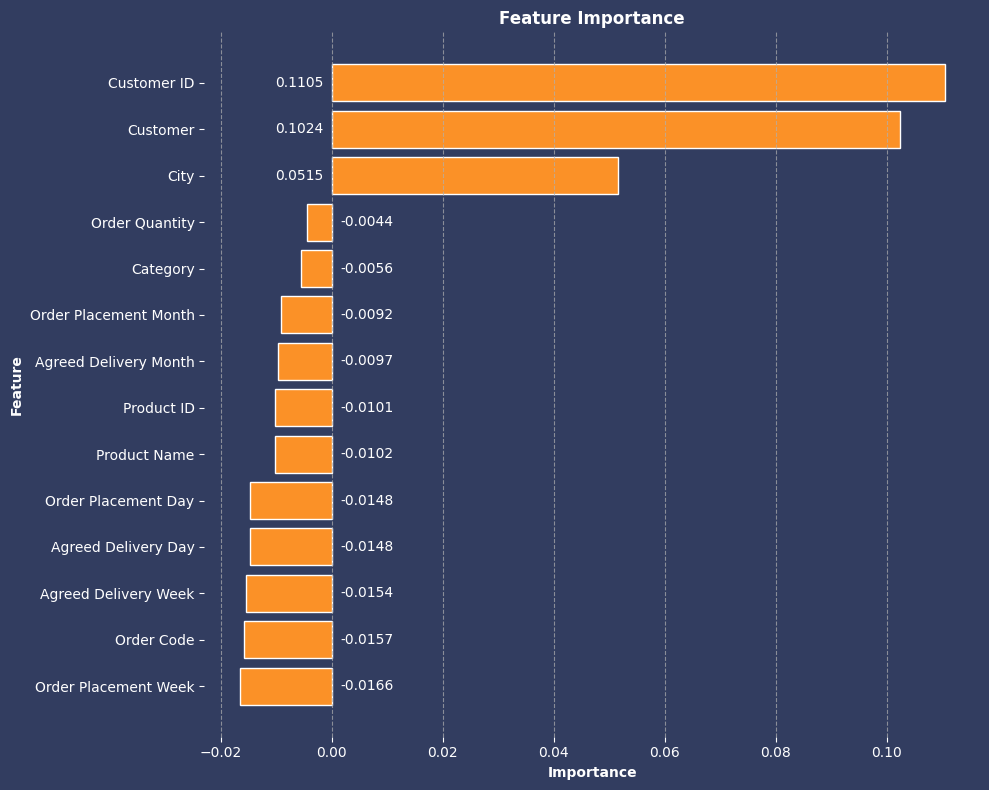

In [178]:
plt.figure(figsize=(10, 8), facecolor='#323D60')
ax = plt.axes()
ax.set_facecolor("#323D60")
bars = plt.barh(data=feature_importance_df.sort_values(by='Importance', ascending=True), y='Feature', width='Importance', color='#FB9127', edgecolor='white')

plt.title('Feature Importance', color='#FFFFFF', fontweight='bold')
plt.xlabel('Importance', color='#FFFFFF', fontweight='bold')
plt.ylabel('Feature', color='#FFFFFF', fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().tick_params(axis='y', colors='#FFFFFF')
plt.gca().tick_params(axis='x', colors='#FFFFFF')

# Remove axis spines
plt.gca().spines[['top', 'right', 'bottom', 'left']].set_visible(False)

# Add data labels
for bar in bars:
    width = bar.get_width()
    if width < 0:
        plt.text(0.0015, bar.get_y() + bar.get_height()/2, '{:.4f}'.format(width), ha='left', va='center', color='#FFFFFF', fontsize=10)
    else:
        plt.text(-0.0015, bar.get_y() + bar.get_height()/2, '{:.4f}'.format(width), ha='right', va='center', color='#FFFFFF', fontsize=10)

# Save the plot as an image
plt.savefig('feature_importance.png', bbox_inches='tight', pad_inches=0.1)

plt.tight_layout()
plt.show()
